In [1]:
import librosa
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct
from scipy.signal import spectrogram
import operator
import pickle
import time
import csv
from random import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import metrics
import logging

## for GPU only

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
print(device)

cuda:0


### CHOICE 1 : Network without dropout or batch norm
- comment line `net.to(device)` to run on CPU

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1,128,3)
        self.conv2 = nn.Conv2d(128,384,3)
        self.conv3 = nn.Conv2d(384,768,3)
        self.conv4 = nn.Conv2d(768,2048,3)
        self.conv5 = nn.Conv2d(2048,50,1) # network with 50 outputs
#         self.conv5 = nn.Conv2d(2048,10,1) # network with 10 outputs
        self.pool1 = nn.MaxPool2d((2,4),(2,4))
        self.pool2 = nn.MaxPool2d((2,4),(2,4))
        self.pool3 = nn.MaxPool2d((2,6),(2,6))
        self.pool4 = nn.MaxPool2d((1,7),(1,7))
#         self.sig = nn.Sigmoid()
        
    def forward(self,x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))
        x = self.conv5(x)
        x = x.view(-1, 50) # network with 50 outputs
#         x = x.view(-1,10) # network with 10 outputs
#         x = self.sig(x)
        return x
    
net = Net()
net.to(device)


Net(
  (conv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(128, 384, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(384, 768, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(768, 2048, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(2048, 50, kernel_size=(1, 1), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=(2, 6), stride=(2, 6), padding=0, dilation=1, ceil_mode=False)
  (pool4): MaxPool2d(kernel_size=(1, 7), stride=(1, 7), padding=0, dilation=1, ceil_mode=False)
)

### CHOICE 2 : Network with drop out and batch norm
- comment the line `net.to(device)` to run on CPU

In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1,128,3)
        self.norm1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128,384,3)
        self.norm2 = nn.BatchNorm2d(384)
        self.conv3 = nn.Conv2d(384,768,3)
        self.norm3 = nn.BatchNorm2d(768)
        self.conv4 = nn.Conv2d(768,2048,3)
        self.conv5 = nn.Conv2d(2048,50,1) # network with 50 outputs
#         self.conv5 = nn.Conv2d(2048,10,1) # network with 10 outputs
        self.pool1 = nn.MaxPool2d((2,4),(2,4))
        self.pool2 = nn.MaxPool2d((2,4),(2,4))
        self.pool3 = nn.MaxPool2d((2,6),(2,6))
        self.pool4 = nn.MaxPool2d((1,7),(1,7))
        self.drop = nn.Dropout2d(.5)
#         self.sig = nn.Sigmoid()
        
    def forward(self,x):
        x = self.pool1(F.relu(self.norm1(self.conv1(x))))
        x = self.pool2(self.drop(F.relu(self.norm2(self.conv2(x)))))
        x = self.pool3(self.drop(F.relu(self.norm3(self.conv3(x)))))
        x = self.pool4(F.relu(self.conv4(x)))
        x = self.conv5(x)
        x = x.view(-1, 50) # network with 50 outputs
#         x = x.view(-1,10) # network with 10 outputs
#         x = self.sig(x)
        return x
    
net = Net()
net.to(device)

Net(
  (conv1): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1))
  (norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 384, kernel_size=(3, 3), stride=(1, 1))
  (norm2): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(384, 768, kernel_size=(3, 3), stride=(1, 1))
  (norm3): BatchNorm2d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(768, 2048, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(2048, 50, kernel_size=(1, 1), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=(2, 6), stride=(2, 6), padding=0, dilation=1, ceil_mode=False)
  (pool4): MaxPool2d(kernel_size=(1, 7), stride=(1, 7), padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout2d(p

### Specify file to load pre-saved network parameters IF NETWORK PARAMETERS SAVED
- specify filename in `filename`
- following trained networks available
 - network_10_epoch_10_output_norm_all_ex.pt
 - network_10_epoch_BNDO_norm_all_ex.pt
 - network_shuffled.pt
 - network_10_epoch_1.pt
 - network_10_epoch_norm_all_ex.pt
 - network_10_epoch_2.pt
 - network_10_epoch_norm_binwise.pt

In [ ]:
filename = 'network_10_epoch_BNDO_norm_all_ex.pt'
net.load_state_dict(torch.load(os.path.join('./networks',filename)))
net.eval()

### creating the training , test and validation dataset

In [ ]:
# indices = list(np.arange(len(keys)))
# shuffle(indices)
# train_ind = indices[0:15516]
# val_ind = indices[15517:20689]
# test_ind = indices[20690:]
# print(len(train_ind))
# print(len(val_ind))
# print(len(test_ind))
# with open('train_ind.pickle','wb') as handle:
#     pickle.dump(train_ind,handle)
# with open('val_ind.pickle','wb') as handle:
#     pickle.dump(val_ind,handle)
# with open('test_ind.pickle','wb') as handle:
#     pickle.dump(test_ind,handle)

- available datasets:
    - combined_dict_norm_all_examples.pickle
    - combined_dict_norm_binwise.pickle
    - combined_dict_norm_per.pickle
    - combined_dict_updated.pickle - network_10_epoch_1
    - combined_dict_norm_all_examples_newSpecs.pkl

In [5]:
with open('../database/train_ind.pickle','rb') as handle:
    train_ind = pickle.load(handle)
with open('../database/val_ind.pickle','rb') as handle:
    val_ind = pickle.load(handle)
with open('../database/test_ind.pickle','rb') as handle:
    test_ind = pickle.load(handle)
with open('../database/combined_dict_norm_all_examples.pickle','rb') as handle:
    combined_dict = pickle.load(handle)
with open('../database/sorted_tags.pickle', 'rb') as handle:
    sorted_stats = pickle.load(handle)

# TRAINING

### loading the stored training, test and validation data

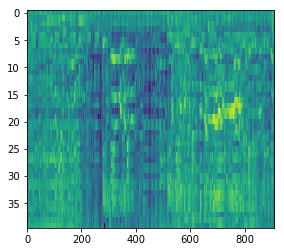

In [6]:
# TEST TO CHECK CONTENTS OF DICTIONARY
plt.imshow(combined_dict['2']['mel_spectrum'][0],aspect=20)
plt.show()

### Calculating weights for weighted inary Cross Entropy Loss

In [7]:
pos_weight = []
for i in range(50): # make 50 for 50 output
    pos_weight.append(sorted_stats[0][1]/sorted_stats[i][1])
pos_weight = np.array(pos_weight).reshape(1,50) # make 50 for 50 output
print(pos_weight)
pos_weight = torch.from_numpy(pos_weight)
pos_weight = pos_weight.float()
print(type(pos_weight))

[[ 1.          1.13576779  1.36791655  1.64251862  1.77794064  1.86759045
   1.92616118  2.04639393  2.10407632  2.35992218  2.4805726   2.54564533
   2.65717415  2.80624639  2.82585906  3.2917232   3.4781362   3.74382716
   3.79358874  4.00660611  4.09797297  4.18998273  4.43915828  4.46777164
   4.59905213  4.73365854  4.77559055  4.84231537  4.87638191  4.87638191
   4.92588832  5.23974082  5.87409201  6.54790823  7.02170767  7.05232558
   7.2962406   7.46461538  7.4761171   7.53416149  7.53416149  7.65299685
   7.78812199  8.43826087  8.46771379  8.71095153  8.96857671  9.60792079
   9.60792079  9.90204082]]
<class 'torch.Tensor'>


### Loss function and Optimization functions

In [8]:
# criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight).cuda()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [9]:
keys = list(combined_dict.keys())
print(len(keys))

25863


- comment the line `inputs = inputs.to(device)` and `labels = labels.to(device)` to run on CPU

In [10]:
# remember to change the name of file before execution
batch_size=4
num_channels=1
start_time = time.time()
loss_hist=[]
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    loss_epoch = []
    #creating a mini batch
    for i in range(0,len(train_ind),4):
        shp = combined_dict[keys[train_ind[i]]]['mel_spectrum'][0].shape
        lab_shp = combined_dict[keys[train_ind[i]]]['output'].shape[0] # outputs 50 labels
#         lab_shp=10 # outputs 10 labels
        inputs = np.zeros((batch_size,num_channels,shp[0],shp[1]+1))
        labels = np.zeros((batch_size,lab_shp))
        for j in range(4):
            inputs[j,0,:,0:-1] = combined_dict[keys[train_ind[i+j]]]['mel_spectrum'][0]
            labels[j,:] = combined_dict[keys[train_ind[i+j]]]['output'] # remove last indexing if output is 50 labels
#             labels[j,:] = labels[j,:]*np.arange(50) # was done for crossentropyloss
        inputs = torch.from_numpy(inputs)
        inputs = inputs.float()
        labels = torch.from_numpy(labels)
        labels = labels.float()
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
#         print(i)
        if i % 20 == 0:   # every 50 mini-batches 
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 5))
            loss_epoch.append(running_loss/5)
            running_loss = 0.0
    loss_hist.append(loss_epoch)
end_time = time.time()
print('Finished Training')
print('Exe. Time:',end_time-start_time)



[1,     1] loss: 0.151
[1,    21] loss: 0.765
[1,    41] loss: 0.782
[1,    61] loss: 0.812
[1,    81] loss: 0.761
[1,   101] loss: 0.809
[1,   121] loss: 0.762
[1,   141] loss: 0.746
[1,   161] loss: 0.713
[1,   181] loss: 0.759
[1,   201] loss: 0.708
[1,   221] loss: 0.700
[1,   241] loss: 0.727
[1,   261] loss: 0.655
[1,   281] loss: 0.673
[1,   301] loss: 0.587
[1,   321] loss: 0.644
[1,   341] loss: 0.564
[1,   361] loss: 0.575
[1,   381] loss: 0.571
[1,   401] loss: 0.568
[1,   421] loss: 0.616
[1,   441] loss: 0.506
[1,   461] loss: 0.521
[1,   481] loss: 0.576
[1,   501] loss: 0.565
[1,   521] loss: 0.587
[1,   541] loss: 0.553
[1,   561] loss: 0.507
[1,   581] loss: 0.427
[1,   601] loss: 0.574
[1,   621] loss: 0.533
[1,   641] loss: 0.540
[1,   661] loss: 0.508
[1,   681] loss: 0.507
[1,   701] loss: 0.554
[1,   721] loss: 0.483
[1,   741] loss: 0.637
[1,   761] loss: 0.499
[1,   781] loss: 0.593
[1,   801] loss: 0.544
[1,   821] loss: 0.503
[1,   841] loss: 0.540
[1,   861] 

[1,  7161] loss: 0.548
[1,  7181] loss: 0.487
[1,  7201] loss: 0.396
[1,  7221] loss: 0.607
[1,  7241] loss: 0.589
[1,  7261] loss: 0.499
[1,  7281] loss: 0.610
[1,  7301] loss: 0.500
[1,  7321] loss: 0.568
[1,  7341] loss: 0.405
[1,  7361] loss: 0.441
[1,  7381] loss: 0.345
[1,  7401] loss: 0.472
[1,  7421] loss: 0.438
[1,  7441] loss: 0.498
[1,  7461] loss: 0.311
[1,  7481] loss: 0.510
[1,  7501] loss: 0.501
[1,  7521] loss: 0.513
[1,  7541] loss: 0.412
[1,  7561] loss: 0.515
[1,  7581] loss: 0.488
[1,  7601] loss: 0.553
[1,  7621] loss: 0.437
[1,  7641] loss: 0.450
[1,  7661] loss: 0.434
[1,  7681] loss: 0.574
[1,  7701] loss: 0.490
[1,  7721] loss: 0.411
[1,  7741] loss: 0.500
[1,  7761] loss: 0.495
[1,  7781] loss: 0.444
[1,  7801] loss: 0.484
[1,  7821] loss: 0.377
[1,  7841] loss: 0.589
[1,  7861] loss: 0.344
[1,  7881] loss: 0.576
[1,  7901] loss: 0.350
[1,  7921] loss: 0.442
[1,  7941] loss: 0.298
[1,  7961] loss: 0.564
[1,  7981] loss: 0.386
[1,  8001] loss: 0.500
[1,  8021] 

[1, 14321] loss: 0.477
[1, 14341] loss: 0.521
[1, 14361] loss: 0.476
[1, 14381] loss: 0.485
[1, 14401] loss: 0.506
[1, 14421] loss: 0.545
[1, 14441] loss: 0.489
[1, 14461] loss: 0.429
[1, 14481] loss: 0.475
[1, 14501] loss: 0.496
[1, 14521] loss: 0.429
[1, 14541] loss: 0.504
[1, 14561] loss: 0.552
[1, 14581] loss: 0.387
[1, 14601] loss: 0.488
[1, 14621] loss: 0.464
[1, 14641] loss: 0.603
[1, 14661] loss: 0.364
[1, 14681] loss: 0.452
[1, 14701] loss: 0.455
[1, 14721] loss: 0.351
[1, 14741] loss: 0.477
[1, 14761] loss: 0.507
[1, 14781] loss: 0.508
[1, 14801] loss: 0.384
[1, 14821] loss: 0.452
[1, 14841] loss: 0.363
[1, 14861] loss: 0.544
[1, 14881] loss: 0.536
[1, 14901] loss: 0.533
[1, 14921] loss: 0.421
[1, 14941] loss: 0.520
[1, 14961] loss: 0.576
[1, 14981] loss: 0.414
[1, 15001] loss: 0.414
[1, 15021] loss: 0.465
[1, 15041] loss: 0.454
[1, 15061] loss: 0.365
[1, 15081] loss: 0.475
[1, 15101] loss: 0.406
[1, 15121] loss: 0.324
[1, 15141] loss: 0.411
[1, 15161] loss: 0.367
[1, 15181] 

[2,  5961] loss: 0.481
[2,  5981] loss: 0.496
[2,  6001] loss: 0.580
[2,  6021] loss: 0.398
[2,  6041] loss: 0.543
[2,  6061] loss: 0.492
[2,  6081] loss: 0.431
[2,  6101] loss: 0.386
[2,  6121] loss: 0.476
[2,  6141] loss: 0.441
[2,  6161] loss: 0.543
[2,  6181] loss: 0.464
[2,  6201] loss: 0.401
[2,  6221] loss: 0.506
[2,  6241] loss: 0.395
[2,  6261] loss: 0.468
[2,  6281] loss: 0.412
[2,  6301] loss: 0.435
[2,  6321] loss: 0.326
[2,  6341] loss: 0.370
[2,  6361] loss: 0.348
[2,  6381] loss: 0.410
[2,  6401] loss: 0.452
[2,  6421] loss: 0.458
[2,  6441] loss: 0.504
[2,  6461] loss: 0.292
[2,  6481] loss: 0.367
[2,  6501] loss: 0.413
[2,  6521] loss: 0.393
[2,  6541] loss: 0.398
[2,  6561] loss: 0.500
[2,  6581] loss: 0.472
[2,  6601] loss: 0.460
[2,  6621] loss: 0.402
[2,  6641] loss: 0.445
[2,  6661] loss: 0.521
[2,  6681] loss: 0.461
[2,  6701] loss: 0.499
[2,  6721] loss: 0.495
[2,  6741] loss: 0.596
[2,  6761] loss: 0.366
[2,  6781] loss: 0.519
[2,  6801] loss: 0.403
[2,  6821] 

[2, 13121] loss: 0.359
[2, 13141] loss: 0.453
[2, 13161] loss: 0.481
[2, 13181] loss: 0.323
[2, 13201] loss: 0.356
[2, 13221] loss: 0.403
[2, 13241] loss: 0.433
[2, 13261] loss: 0.338
[2, 13281] loss: 0.521
[2, 13301] loss: 0.383
[2, 13321] loss: 0.426
[2, 13341] loss: 0.510
[2, 13361] loss: 0.437
[2, 13381] loss: 0.386
[2, 13401] loss: 0.432
[2, 13421] loss: 0.474
[2, 13441] loss: 0.430
[2, 13461] loss: 0.423
[2, 13481] loss: 0.331
[2, 13501] loss: 0.393
[2, 13521] loss: 0.455
[2, 13541] loss: 0.360
[2, 13561] loss: 0.401
[2, 13581] loss: 0.512
[2, 13601] loss: 0.343
[2, 13621] loss: 0.440
[2, 13641] loss: 0.360
[2, 13661] loss: 0.476
[2, 13681] loss: 0.541
[2, 13701] loss: 0.334
[2, 13721] loss: 0.427
[2, 13741] loss: 0.453
[2, 13761] loss: 0.401
[2, 13781] loss: 0.394
[2, 13801] loss: 0.400
[2, 13821] loss: 0.459
[2, 13841] loss: 0.402
[2, 13861] loss: 0.374
[2, 13881] loss: 0.396
[2, 13901] loss: 0.407
[2, 13921] loss: 0.356
[2, 13941] loss: 0.424
[2, 13961] loss: 0.404
[2, 13981] 

[3,  4761] loss: 0.404
[3,  4781] loss: 0.487
[3,  4801] loss: 0.322
[3,  4821] loss: 0.374
[3,  4841] loss: 0.505
[3,  4861] loss: 0.328
[3,  4881] loss: 0.383
[3,  4901] loss: 0.463
[3,  4921] loss: 0.451
[3,  4941] loss: 0.446
[3,  4961] loss: 0.408
[3,  4981] loss: 0.405
[3,  5001] loss: 0.378
[3,  5021] loss: 0.546
[3,  5041] loss: 0.339
[3,  5061] loss: 0.358
[3,  5081] loss: 0.362
[3,  5101] loss: 0.443
[3,  5121] loss: 0.442
[3,  5141] loss: 0.398
[3,  5161] loss: 0.420
[3,  5181] loss: 0.446
[3,  5201] loss: 0.455
[3,  5221] loss: 0.382
[3,  5241] loss: 0.341
[3,  5261] loss: 0.484
[3,  5281] loss: 0.513
[3,  5301] loss: 0.469
[3,  5321] loss: 0.428
[3,  5341] loss: 0.497
[3,  5361] loss: 0.560
[3,  5381] loss: 0.465
[3,  5401] loss: 0.366
[3,  5421] loss: 0.328
[3,  5441] loss: 0.591
[3,  5461] loss: 0.409
[3,  5481] loss: 0.387
[3,  5501] loss: 0.412
[3,  5521] loss: 0.504
[3,  5541] loss: 0.415
[3,  5561] loss: 0.364
[3,  5581] loss: 0.425
[3,  5601] loss: 0.485
[3,  5621] 

[3, 11921] loss: 0.429
[3, 11941] loss: 0.488
[3, 11961] loss: 0.384
[3, 11981] loss: 0.476
[3, 12001] loss: 0.373
[3, 12021] loss: 0.397
[3, 12041] loss: 0.383
[3, 12061] loss: 0.457
[3, 12081] loss: 0.447
[3, 12101] loss: 0.398
[3, 12121] loss: 0.454
[3, 12141] loss: 0.354
[3, 12161] loss: 0.391
[3, 12181] loss: 0.376
[3, 12201] loss: 0.426
[3, 12221] loss: 0.404
[3, 12241] loss: 0.440
[3, 12261] loss: 0.364
[3, 12281] loss: 0.363
[3, 12301] loss: 0.450
[3, 12321] loss: 0.459
[3, 12341] loss: 0.391
[3, 12361] loss: 0.360
[3, 12381] loss: 0.320
[3, 12401] loss: 0.444
[3, 12421] loss: 0.389
[3, 12441] loss: 0.372
[3, 12461] loss: 0.490
[3, 12481] loss: 0.358
[3, 12501] loss: 0.403
[3, 12521] loss: 0.418
[3, 12541] loss: 0.439
[3, 12561] loss: 0.357
[3, 12581] loss: 0.372
[3, 12601] loss: 0.417
[3, 12621] loss: 0.378
[3, 12641] loss: 0.505
[3, 12661] loss: 0.445
[3, 12681] loss: 0.330
[3, 12701] loss: 0.331
[3, 12721] loss: 0.427
[3, 12741] loss: 0.417
[3, 12761] loss: 0.493
[3, 12781] 

[4,  3561] loss: 0.424
[4,  3581] loss: 0.401
[4,  3601] loss: 0.404
[4,  3621] loss: 0.376
[4,  3641] loss: 0.402
[4,  3661] loss: 0.312
[4,  3681] loss: 0.343
[4,  3701] loss: 0.412
[4,  3721] loss: 0.409
[4,  3741] loss: 0.374
[4,  3761] loss: 0.354
[4,  3781] loss: 0.406
[4,  3801] loss: 0.318
[4,  3821] loss: 0.330
[4,  3841] loss: 0.494
[4,  3861] loss: 0.363
[4,  3881] loss: 0.416
[4,  3901] loss: 0.365
[4,  3921] loss: 0.462
[4,  3941] loss: 0.445
[4,  3961] loss: 0.395
[4,  3981] loss: 0.342
[4,  4001] loss: 0.330
[4,  4021] loss: 0.388
[4,  4041] loss: 0.381
[4,  4061] loss: 0.375
[4,  4081] loss: 0.347
[4,  4101] loss: 0.468
[4,  4121] loss: 0.418
[4,  4141] loss: 0.375
[4,  4161] loss: 0.467
[4,  4181] loss: 0.384
[4,  4201] loss: 0.363
[4,  4221] loss: 0.302
[4,  4241] loss: 0.393
[4,  4261] loss: 0.299
[4,  4281] loss: 0.582
[4,  4301] loss: 0.352
[4,  4321] loss: 0.373
[4,  4341] loss: 0.437
[4,  4361] loss: 0.336
[4,  4381] loss: 0.328
[4,  4401] loss: 0.364
[4,  4421] 

[4, 10721] loss: 0.490
[4, 10741] loss: 0.391
[4, 10761] loss: 0.315
[4, 10781] loss: 0.508
[4, 10801] loss: 0.468
[4, 10821] loss: 0.349
[4, 10841] loss: 0.295
[4, 10861] loss: 0.298
[4, 10881] loss: 0.477
[4, 10901] loss: 0.453
[4, 10921] loss: 0.366
[4, 10941] loss: 0.414
[4, 10961] loss: 0.503
[4, 10981] loss: 0.410
[4, 11001] loss: 0.431
[4, 11021] loss: 0.345
[4, 11041] loss: 0.421
[4, 11061] loss: 0.361
[4, 11081] loss: 0.439
[4, 11101] loss: 0.314
[4, 11121] loss: 0.479
[4, 11141] loss: 0.310
[4, 11161] loss: 0.365
[4, 11181] loss: 0.358
[4, 11201] loss: 0.350
[4, 11221] loss: 0.314
[4, 11241] loss: 0.480
[4, 11261] loss: 0.347
[4, 11281] loss: 0.463
[4, 11301] loss: 0.514
[4, 11321] loss: 0.350
[4, 11341] loss: 0.399
[4, 11361] loss: 0.474
[4, 11381] loss: 0.334
[4, 11401] loss: 0.406
[4, 11421] loss: 0.438
[4, 11441] loss: 0.464
[4, 11461] loss: 0.371
[4, 11481] loss: 0.314
[4, 11501] loss: 0.396
[4, 11521] loss: 0.395
[4, 11541] loss: 0.308
[4, 11561] loss: 0.354
[4, 11581] 

[5,  2361] loss: 0.352
[5,  2381] loss: 0.405
[5,  2401] loss: 0.318
[5,  2421] loss: 0.380
[5,  2441] loss: 0.356
[5,  2461] loss: 0.471
[5,  2481] loss: 0.414
[5,  2501] loss: 0.417
[5,  2521] loss: 0.398
[5,  2541] loss: 0.409
[5,  2561] loss: 0.315
[5,  2581] loss: 0.411
[5,  2601] loss: 0.391
[5,  2621] loss: 0.384
[5,  2641] loss: 0.338
[5,  2661] loss: 0.315
[5,  2681] loss: 0.405
[5,  2701] loss: 0.327
[5,  2721] loss: 0.402
[5,  2741] loss: 0.378
[5,  2761] loss: 0.373
[5,  2781] loss: 0.302
[5,  2801] loss: 0.508
[5,  2821] loss: 0.524
[5,  2841] loss: 0.357
[5,  2861] loss: 0.390
[5,  2881] loss: 0.353
[5,  2901] loss: 0.430
[5,  2921] loss: 0.466
[5,  2941] loss: 0.374
[5,  2961] loss: 0.323
[5,  2981] loss: 0.376
[5,  3001] loss: 0.281
[5,  3021] loss: 0.403
[5,  3041] loss: 0.375
[5,  3061] loss: 0.401
[5,  3081] loss: 0.330
[5,  3101] loss: 0.317
[5,  3121] loss: 0.316
[5,  3141] loss: 0.446
[5,  3161] loss: 0.291
[5,  3181] loss: 0.365
[5,  3201] loss: 0.411
[5,  3221] 

[5,  9521] loss: 0.515
[5,  9541] loss: 0.386
[5,  9561] loss: 0.413
[5,  9581] loss: 0.465
[5,  9601] loss: 0.327
[5,  9621] loss: 0.316
[5,  9641] loss: 0.295
[5,  9661] loss: 0.407
[5,  9681] loss: 0.433
[5,  9701] loss: 0.353
[5,  9721] loss: 0.339
[5,  9741] loss: 0.333
[5,  9761] loss: 0.371
[5,  9781] loss: 0.378
[5,  9801] loss: 0.304
[5,  9821] loss: 0.384
[5,  9841] loss: 0.415
[5,  9861] loss: 0.366
[5,  9881] loss: 0.336
[5,  9901] loss: 0.436
[5,  9921] loss: 0.369
[5,  9941] loss: 0.384
[5,  9961] loss: 0.394
[5,  9981] loss: 0.297
[5, 10001] loss: 0.357
[5, 10021] loss: 0.304
[5, 10041] loss: 0.610
[5, 10061] loss: 0.492
[5, 10081] loss: 0.298
[5, 10101] loss: 0.349
[5, 10121] loss: 0.384
[5, 10141] loss: 0.360
[5, 10161] loss: 0.414
[5, 10181] loss: 0.317
[5, 10201] loss: 0.394
[5, 10221] loss: 0.292
[5, 10241] loss: 0.508
[5, 10261] loss: 0.336
[5, 10281] loss: 0.344
[5, 10301] loss: 0.370
[5, 10321] loss: 0.357
[5, 10341] loss: 0.323
[5, 10361] loss: 0.402
[5, 10381] 

[6,  1161] loss: 0.355
[6,  1181] loss: 0.311
[6,  1201] loss: 0.356
[6,  1221] loss: 0.407
[6,  1241] loss: 0.312
[6,  1261] loss: 0.338
[6,  1281] loss: 0.402
[6,  1301] loss: 0.362
[6,  1321] loss: 0.405
[6,  1341] loss: 0.378
[6,  1361] loss: 0.386
[6,  1381] loss: 0.481
[6,  1401] loss: 0.523
[6,  1421] loss: 0.391
[6,  1441] loss: 0.370
[6,  1461] loss: 0.307
[6,  1481] loss: 0.393
[6,  1501] loss: 0.329
[6,  1521] loss: 0.337
[6,  1541] loss: 0.406
[6,  1561] loss: 0.331
[6,  1581] loss: 0.351
[6,  1601] loss: 0.323
[6,  1621] loss: 0.378
[6,  1641] loss: 0.410
[6,  1661] loss: 0.364
[6,  1681] loss: 0.371
[6,  1701] loss: 0.354
[6,  1721] loss: 0.336
[6,  1741] loss: 0.305
[6,  1761] loss: 0.490
[6,  1781] loss: 0.403
[6,  1801] loss: 0.373
[6,  1821] loss: 0.444
[6,  1841] loss: 0.497
[6,  1861] loss: 0.454
[6,  1881] loss: 0.375
[6,  1901] loss: 0.420
[6,  1921] loss: 0.298
[6,  1941] loss: 0.316
[6,  1961] loss: 0.388
[6,  1981] loss: 0.401
[6,  2001] loss: 0.406
[6,  2021] 

[6,  8321] loss: 0.323
[6,  8341] loss: 0.390
[6,  8361] loss: 0.290
[6,  8381] loss: 0.343
[6,  8401] loss: 0.347
[6,  8421] loss: 0.430
[6,  8441] loss: 0.453
[6,  8461] loss: 0.418
[6,  8481] loss: 0.442
[6,  8501] loss: 0.386
[6,  8521] loss: 0.353
[6,  8541] loss: 0.391
[6,  8561] loss: 0.336
[6,  8581] loss: 0.293
[6,  8601] loss: 0.290
[6,  8621] loss: 0.257
[6,  8641] loss: 0.314
[6,  8661] loss: 0.347
[6,  8681] loss: 0.401
[6,  8701] loss: 0.335
[6,  8721] loss: 0.486
[6,  8741] loss: 0.393
[6,  8761] loss: 0.391
[6,  8781] loss: 0.376
[6,  8801] loss: 0.393
[6,  8821] loss: 0.311
[6,  8841] loss: 0.351
[6,  8861] loss: 0.429
[6,  8881] loss: 0.349
[6,  8901] loss: 0.327
[6,  8921] loss: 0.539
[6,  8941] loss: 0.401
[6,  8961] loss: 0.405
[6,  8981] loss: 0.394
[6,  9001] loss: 0.341
[6,  9021] loss: 0.325
[6,  9041] loss: 0.258
[6,  9061] loss: 0.323
[6,  9081] loss: 0.363
[6,  9101] loss: 0.422
[6,  9121] loss: 0.348
[6,  9141] loss: 0.417
[6,  9161] loss: 0.320
[6,  9181] 

[6, 15481] loss: 0.320
[6, 15501] loss: 0.271
[7,     1] loss: 0.076
[7,    21] loss: 0.304
[7,    41] loss: 0.326
[7,    61] loss: 0.426
[7,    81] loss: 0.328
[7,   101] loss: 0.402
[7,   121] loss: 0.354
[7,   141] loss: 0.394
[7,   161] loss: 0.325
[7,   181] loss: 0.383
[7,   201] loss: 0.291
[7,   221] loss: 0.515
[7,   241] loss: 0.406
[7,   261] loss: 0.326
[7,   281] loss: 0.327
[7,   301] loss: 0.229
[7,   321] loss: 0.372
[7,   341] loss: 0.242
[7,   361] loss: 0.302
[7,   381] loss: 0.301
[7,   401] loss: 0.352
[7,   421] loss: 0.437
[7,   441] loss: 0.344
[7,   461] loss: 0.373
[7,   481] loss: 0.378
[7,   501] loss: 0.374
[7,   521] loss: 0.427
[7,   541] loss: 0.379
[7,   561] loss: 0.404
[7,   581] loss: 0.268
[7,   601] loss: 0.377
[7,   621] loss: 0.367
[7,   641] loss: 0.323
[7,   661] loss: 0.346
[7,   681] loss: 0.324
[7,   701] loss: 0.417
[7,   721] loss: 0.252
[7,   741] loss: 0.435
[7,   761] loss: 0.347
[7,   781] loss: 0.442
[7,   801] loss: 0.328
[7,   821] 

[7,  7121] loss: 0.315
[7,  7141] loss: 0.315
[7,  7161] loss: 0.420
[7,  7181] loss: 0.370
[7,  7201] loss: 0.315
[7,  7221] loss: 0.378
[7,  7241] loss: 0.472
[7,  7261] loss: 0.353
[7,  7281] loss: 0.435
[7,  7301] loss: 0.365
[7,  7321] loss: 0.408
[7,  7341] loss: 0.300
[7,  7361] loss: 0.331
[7,  7381] loss: 0.290
[7,  7401] loss: 0.331
[7,  7421] loss: 0.380
[7,  7441] loss: 0.329
[7,  7461] loss: 0.260
[7,  7481] loss: 0.371
[7,  7501] loss: 0.350
[7,  7521] loss: 0.380
[7,  7541] loss: 0.347
[7,  7561] loss: 0.380
[7,  7581] loss: 0.385
[7,  7601] loss: 0.329
[7,  7621] loss: 0.265
[7,  7641] loss: 0.366
[7,  7661] loss: 0.317
[7,  7681] loss: 0.355
[7,  7701] loss: 0.338
[7,  7721] loss: 0.360
[7,  7741] loss: 0.356
[7,  7761] loss: 0.372
[7,  7781] loss: 0.304
[7,  7801] loss: 0.344
[7,  7821] loss: 0.286
[7,  7841] loss: 0.406
[7,  7861] loss: 0.296
[7,  7881] loss: 0.450
[7,  7901] loss: 0.282
[7,  7921] loss: 0.350
[7,  7941] loss: 0.225
[7,  7961] loss: 0.436
[7,  7981] 

[7, 14281] loss: 0.293
[7, 14301] loss: 0.372
[7, 14321] loss: 0.374
[7, 14341] loss: 0.373
[7, 14361] loss: 0.316
[7, 14381] loss: 0.373
[7, 14401] loss: 0.373
[7, 14421] loss: 0.420
[7, 14441] loss: 0.401
[7, 14461] loss: 0.287
[7, 14481] loss: 0.389
[7, 14501] loss: 0.391
[7, 14521] loss: 0.307
[7, 14541] loss: 0.343
[7, 14561] loss: 0.379
[7, 14581] loss: 0.268
[7, 14601] loss: 0.367
[7, 14621] loss: 0.364
[7, 14641] loss: 0.385
[7, 14661] loss: 0.315
[7, 14681] loss: 0.365
[7, 14701] loss: 0.359
[7, 14721] loss: 0.240
[7, 14741] loss: 0.401
[7, 14761] loss: 0.318
[7, 14781] loss: 0.394
[7, 14801] loss: 0.294
[7, 14821] loss: 0.319
[7, 14841] loss: 0.266
[7, 14861] loss: 0.431
[7, 14881] loss: 0.413
[7, 14901] loss: 0.368
[7, 14921] loss: 0.280
[7, 14941] loss: 0.391
[7, 14961] loss: 0.477
[7, 14981] loss: 0.343
[7, 15001] loss: 0.272
[7, 15021] loss: 0.327
[7, 15041] loss: 0.320
[7, 15061] loss: 0.275
[7, 15081] loss: 0.382
[7, 15101] loss: 0.303
[7, 15121] loss: 0.271
[7, 15141] 

[8,  5921] loss: 0.365
[8,  5941] loss: 0.393
[8,  5961] loss: 0.334
[8,  5981] loss: 0.356
[8,  6001] loss: 0.380
[8,  6021] loss: 0.254
[8,  6041] loss: 0.395
[8,  6061] loss: 0.324
[8,  6081] loss: 0.342
[8,  6101] loss: 0.314
[8,  6121] loss: 0.377
[8,  6141] loss: 0.321
[8,  6161] loss: 0.447
[8,  6181] loss: 0.363
[8,  6201] loss: 0.296
[8,  6221] loss: 0.398
[8,  6241] loss: 0.317
[8,  6261] loss: 0.386
[8,  6281] loss: 0.275
[8,  6301] loss: 0.315
[8,  6321] loss: 0.221
[8,  6341] loss: 0.253
[8,  6361] loss: 0.278
[8,  6381] loss: 0.332
[8,  6401] loss: 0.323
[8,  6421] loss: 0.318
[8,  6441] loss: 0.407
[8,  6461] loss: 0.221
[8,  6481] loss: 0.273
[8,  6501] loss: 0.322
[8,  6521] loss: 0.298
[8,  6541] loss: 0.296
[8,  6561] loss: 0.324
[8,  6581] loss: 0.348
[8,  6601] loss: 0.268
[8,  6621] loss: 0.295
[8,  6641] loss: 0.390
[8,  6661] loss: 0.334
[8,  6681] loss: 0.380
[8,  6701] loss: 0.413
[8,  6721] loss: 0.436
[8,  6741] loss: 0.418
[8,  6761] loss: 0.291
[8,  6781] 

[8, 13081] loss: 0.312
[8, 13101] loss: 0.426
[8, 13121] loss: 0.296
[8, 13141] loss: 0.332
[8, 13161] loss: 0.366
[8, 13181] loss: 0.243
[8, 13201] loss: 0.315
[8, 13221] loss: 0.293
[8, 13241] loss: 0.316
[8, 13261] loss: 0.325
[8, 13281] loss: 0.395
[8, 13301] loss: 0.286
[8, 13321] loss: 0.315
[8, 13341] loss: 0.313
[8, 13361] loss: 0.302
[8, 13381] loss: 0.284
[8, 13401] loss: 0.357
[8, 13421] loss: 0.364
[8, 13441] loss: 0.351
[8, 13461] loss: 0.317
[8, 13481] loss: 0.255
[8, 13501] loss: 0.344
[8, 13521] loss: 0.431
[8, 13541] loss: 0.298
[8, 13561] loss: 0.304
[8, 13581] loss: 0.355
[8, 13601] loss: 0.285
[8, 13621] loss: 0.345
[8, 13641] loss: 0.325
[8, 13661] loss: 0.343
[8, 13681] loss: 0.384
[8, 13701] loss: 0.266
[8, 13721] loss: 0.380
[8, 13741] loss: 0.390
[8, 13761] loss: 0.341
[8, 13781] loss: 0.280
[8, 13801] loss: 0.308
[8, 13821] loss: 0.339
[8, 13841] loss: 0.342
[8, 13861] loss: 0.324
[8, 13881] loss: 0.358
[8, 13901] loss: 0.347
[8, 13921] loss: 0.324
[8, 13941] 

[9,  4721] loss: 0.339
[9,  4741] loss: 0.314
[9,  4761] loss: 0.308
[9,  4781] loss: 0.378
[9,  4801] loss: 0.278
[9,  4821] loss: 0.297
[9,  4841] loss: 0.362
[9,  4861] loss: 0.244
[9,  4881] loss: 0.324
[9,  4901] loss: 0.380
[9,  4921] loss: 0.371
[9,  4941] loss: 0.325
[9,  4961] loss: 0.320
[9,  4981] loss: 0.358
[9,  5001] loss: 0.329
[9,  5021] loss: 0.448
[9,  5041] loss: 0.272
[9,  5061] loss: 0.289
[9,  5081] loss: 0.288
[9,  5101] loss: 0.386
[9,  5121] loss: 0.355
[9,  5141] loss: 0.350
[9,  5161] loss: 0.352
[9,  5181] loss: 0.353
[9,  5201] loss: 0.379
[9,  5221] loss: 0.327
[9,  5241] loss: 0.270
[9,  5261] loss: 0.397
[9,  5281] loss: 0.387
[9,  5301] loss: 0.373
[9,  5321] loss: 0.296
[9,  5341] loss: 0.420
[9,  5361] loss: 0.424
[9,  5381] loss: 0.388
[9,  5401] loss: 0.283
[9,  5421] loss: 0.246
[9,  5441] loss: 0.406
[9,  5461] loss: 0.281
[9,  5481] loss: 0.302
[9,  5501] loss: 0.323
[9,  5521] loss: 0.397
[9,  5541] loss: 0.291
[9,  5561] loss: 0.255
[9,  5581] 

[9, 11881] loss: 0.391
[9, 11901] loss: 0.280
[9, 11921] loss: 0.309
[9, 11941] loss: 0.386
[9, 11961] loss: 0.326
[9, 11981] loss: 0.400
[9, 12001] loss: 0.316
[9, 12021] loss: 0.318
[9, 12041] loss: 0.288
[9, 12061] loss: 0.398
[9, 12081] loss: 0.346
[9, 12101] loss: 0.347
[9, 12121] loss: 0.341
[9, 12141] loss: 0.282
[9, 12161] loss: 0.287
[9, 12181] loss: 0.318
[9, 12201] loss: 0.357
[9, 12221] loss: 0.341
[9, 12241] loss: 0.354
[9, 12261] loss: 0.325
[9, 12281] loss: 0.302
[9, 12301] loss: 0.323
[9, 12321] loss: 0.387
[9, 12341] loss: 0.314
[9, 12361] loss: 0.293
[9, 12381] loss: 0.256
[9, 12401] loss: 0.312
[9, 12421] loss: 0.333
[9, 12441] loss: 0.340
[9, 12461] loss: 0.386
[9, 12481] loss: 0.270
[9, 12501] loss: 0.313
[9, 12521] loss: 0.330
[9, 12541] loss: 0.344
[9, 12561] loss: 0.296
[9, 12581] loss: 0.313
[9, 12601] loss: 0.329
[9, 12621] loss: 0.338
[9, 12641] loss: 0.419
[9, 12661] loss: 0.398
[9, 12681] loss: 0.296
[9, 12701] loss: 0.269
[9, 12721] loss: 0.330
[9, 12741] 

[10,  3361] loss: 0.406
[10,  3381] loss: 0.270
[10,  3401] loss: 0.388
[10,  3421] loss: 0.341
[10,  3441] loss: 0.366
[10,  3461] loss: 0.330
[10,  3481] loss: 0.441
[10,  3501] loss: 0.323
[10,  3521] loss: 0.416
[10,  3541] loss: 0.290
[10,  3561] loss: 0.361
[10,  3581] loss: 0.290
[10,  3601] loss: 0.309
[10,  3621] loss: 0.292
[10,  3641] loss: 0.337
[10,  3661] loss: 0.217
[10,  3681] loss: 0.279
[10,  3701] loss: 0.306
[10,  3721] loss: 0.315
[10,  3741] loss: 0.295
[10,  3761] loss: 0.280
[10,  3781] loss: 0.341
[10,  3801] loss: 0.275
[10,  3821] loss: 0.281
[10,  3841] loss: 0.390
[10,  3861] loss: 0.295
[10,  3881] loss: 0.329
[10,  3901] loss: 0.284
[10,  3921] loss: 0.369
[10,  3941] loss: 0.362
[10,  3961] loss: 0.345
[10,  3981] loss: 0.263
[10,  4001] loss: 0.286
[10,  4021] loss: 0.288
[10,  4041] loss: 0.277
[10,  4061] loss: 0.296
[10,  4081] loss: 0.278
[10,  4101] loss: 0.368
[10,  4121] loss: 0.330
[10,  4141] loss: 0.295
[10,  4161] loss: 0.402
[10,  4181] loss

[10, 10201] loss: 0.345
[10, 10221] loss: 0.243
[10, 10241] loss: 0.455
[10, 10261] loss: 0.273
[10, 10281] loss: 0.293
[10, 10301] loss: 0.303
[10, 10321] loss: 0.318
[10, 10341] loss: 0.300
[10, 10361] loss: 0.348
[10, 10381] loss: 0.313
[10, 10401] loss: 0.227
[10, 10421] loss: 0.334
[10, 10441] loss: 0.342
[10, 10461] loss: 0.309
[10, 10481] loss: 0.244
[10, 10501] loss: 0.319
[10, 10521] loss: 0.339
[10, 10541] loss: 0.432
[10, 10561] loss: 0.221
[10, 10581] loss: 0.346
[10, 10601] loss: 0.321
[10, 10621] loss: 0.412
[10, 10641] loss: 0.255
[10, 10661] loss: 0.338
[10, 10681] loss: 0.286
[10, 10701] loss: 0.318
[10, 10721] loss: 0.378
[10, 10741] loss: 0.300
[10, 10761] loss: 0.264
[10, 10781] loss: 0.391
[10, 10801] loss: 0.422
[10, 10821] loss: 0.294
[10, 10841] loss: 0.244
[10, 10861] loss: 0.254
[10, 10881] loss: 0.389
[10, 10901] loss: 0.387
[10, 10921] loss: 0.302
[10, 10941] loss: 0.320
[10, 10961] loss: 0.421
[10, 10981] loss: 0.337
[10, 11001] loss: 0.347
[10, 11021] loss

### to save the network parameters onto disk

In [ ]:
# change name before saving the network
torch.save(net.state_dict(),'./networks/network_10_epoch_new_model.pt')

# CODE TO VALIDATION SET PERFORMANCE

In [11]:
keys = list(combined_dict.keys())
print(len(keys))

25863


- comment line `inputs = inputs.to(device)` to run on CPU

In [ ]:
batch_size=4
num_channels=1
out_all = np.zeros((1,50))# change for 50
labels_all = np.zeros((1,50)) # change for 50
for i in range(0,len(val_ind),4):
    shp = combined_dict[keys[val_ind[i]]]['mel_spectrum'][0].shape
    lab_shp = combined_dict[keys[val_ind[i]]]['output'].shape[0]
#     lab_shp = 10 # uncomment for 10 output
    inputs = np.zeros((batch_size,num_channels,shp[0],shp[1]+1))
    labels = np.zeros((batch_size,lab_shp))
    for j in range(4):
        inputs[j,0,:,0:-1] = combined_dict[keys[val_ind[i+j]]]['mel_spectrum'][0]
        labels[j,:] = combined_dict[keys[val_ind[i+j]]]['output'] # remove last indexing if output is 50 labels
    labels_all = np.concatenate((labels_all,labels),axis=0)
    inputs = torch.from_numpy(inputs)
    inputs = inputs.float()
    inputs = inputs.to(device)
    outputs = net(inputs)
    temp = outputs.cpu().detach().numpy()
    out_all = np.concatenate((out_all,temp),axis=0)
    if i%100 == 0:
        print(i)    
    
print('Finished')



In [ ]:
labels_all = labels_all[1:,:]
out_all = out_all[1:,:]
print(labels_all.shape)
print(out_all.shape)
out_all_tensor = torch.from_numpy(out_all)
out_all_prob = torch.sigmoid(out_all_tensor).numpy() # for auc_roc
out_all_bin_tensor = torch.round(torch.sigmoid(out_all_tensor))
# out_all_bin = np.where(out_all_prob<.3,0,1) # to change the threshold of rounding
out_all_bin = out_all_bin_tensor.numpy() # for other metrics
print(out_all_bin.shape)

### caluclating the metrics(precision,recall,fscore) using all tags at once

In [ ]:
precision,recall,fscore,support = metrics.precision_recall_fscore_support(labels_all,out_all_bin)

### calculating the AUC-ROC curve

In [ ]:
auc_roc = metrics.roc_auc_score(labels_all,out_all_prob)
print(auc_roc)

# CODE FOR TEST SET

In [12]:
batch_size=4
num_channels=1
out_all = np.zeros((1,50))# change for 50
labels_all = np.zeros((1,50)) # change for 50
auc_all = []
for j in range(10):
    print(j)
    filename = 'network_'+str(j)+'.pt'
    net.load_state_dict(torch.load(os.path.join('./net_ep',filename)))
    net.eval()
    for i in range(0,len(test_ind)-4,4):
        shp = combined_dict[keys[test_ind[i]]]['mel_spectrum'][0].shape
        lab_shp = combined_dict[keys[test_ind[i]]]['output'].shape[0]
    #     lab_shp = 10 # uncomment for 10 output
        inputs = np.zeros((batch_size,num_channels,shp[0],shp[1]+1))
        labels = np.zeros((batch_size,lab_shp))
        for j in range(4):
            inputs[j,0,:,0:-1] = combined_dict[keys[test_ind[i+j]]]['mel_spectrum'][0]
            labels[j,:] = combined_dict[keys[test_ind[i+j]]]['output'] # remove last indexing if output is 50 labels
        labels_all = np.concatenate((labels_all,labels),axis=0)
        inputs = torch.from_numpy(inputs)
        inputs = inputs.float()
        inputs = inputs.to(device)
        outputs = net(inputs)
        temp = outputs.cpu().detach().numpy()
        out_all = np.concatenate((out_all,temp),axis=0)
        if i%100 == 0:
            print(i)
    labels_all = labels_all[1:,:]
    out_all = out_all[1:,:]
    print(labels_all.shape)
    print(out_all.shape)
    out_all_tensor = torch.from_numpy(out_all)
    out_all_prob = torch.sigmoid(out_all_tensor).numpy() # for auc_roc
    out_all_bin_tensor = torch.round(torch.sigmoid(out_all_tensor))
    # out_all_bin = np.where(out_all_prob<.3,0,1) # to change the threshold of rounding
    out_all_bin = out_all_bin_tensor.numpy() # for other metrics
    print(out_all_bin.shape)
    auc_roc = metrics.roc_auc_score(labels_all,out_all_prob)
    auc_all.append(auc_roc)
print('Finished')
    

0
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
(5172, 50)
(5172, 50)
(5172, 50)
1
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
(10343, 50)
(10343, 50)
(10343, 50)
2
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
(15514, 50)
(15514, 50)
(15514, 50)
3
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000


Text(0,0.5,'auc score')

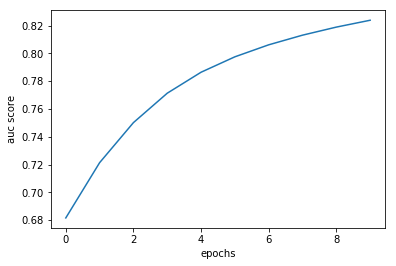

In [19]:
plt.figure()
plt.plot(auc_all)
plt.xlabel('epochs')
plt.ylabel('auc score')

In [ ]:
labels_all = labels_all[1:,:]
out_all = out_all[1:,:]
print(labels_all.shape)
print(out_all.shape)
out_all_tensor = torch.from_numpy(out_all)
out_all_prob = torch.sigmoid(out_all_tensor).numpy() # for auc_roc
out_all_bin_tensor = torch.round(torch.sigmoid(out_all_tensor))
# out_all_bin = np.where(out_all_prob<.3,0,1) # to change the threshold of rounding
out_all_bin = out_all_bin_tensor.numpy() # for other metrics
print(out_all_bin.shape)

In [ ]:
auc_roc = metrics.roc_auc_score(labels_all,out_all_prob)
print(auc_roc)